# Loan Approval Classification

# Imports

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Models 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier

# Data Processing
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.metrics import make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA


# Model Processing
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.pipeline import Pipeline
# K Best columns
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif

# Functions

In [64]:
def check_for_dupes_nans(df:pd.DataFrame):
    """
    Checks for dupes and nulls
    """
    amount_of_dupes = df.duplicated().sum()
    print(f"Null Count: {df.isna().sum()}")
    print(f"Dupe Count: {amount_of_dupes}")

def check_class_imbalance(df:pd.DataFrame, target:pd.Series, col:str):
  counter = Counter(target)
  for k,v in counter.items():
    per = v/len(target) * 100
    print("Class=%s, Count=%d, Percentage=%.3f%%" % (k,v, per))
  
  ax = df[col].value_counts().sort_index().plot(
  kind="bar", 
  title="Count of Reviews by Target", 
  figsize=(10,5)
  )
  ax.set_xlabel(col)
  plt.show()
  
def create_column_transformer( numeric_features, categorical_features):
  
  numeric_features_columns = numeric_features.columns
  numeric_transformer = Pipeline(
      steps=[("scaler", MinMaxScaler()), ("power_tranformer",PowerTransformer())]
  )

  categorical_features_columns = categorical_features.columns
  categorical_transformer = Pipeline(
      steps=[
          ("encoder", OneHotEncoder(handle_unknown="ignore")),
      ]
  )
  preprocessor = ColumnTransformer(
      transformers=[
          ("num", numeric_transformer, numeric_features_columns),
          ("cat", categorical_transformer, categorical_features_columns),
      ]
  )
  
  return preprocessor

def create_pipeline(preprocessor, model, metric_name=None, kbest=None):
    """
    - This function creates our pipeline.
    - Takes a preprocessor which transforms cat/numeric features
    - Can accept a metric
    - Model to test

    Returns:
        Pipeline
    """
    
    steps = [("preprocessor", preprocessor), ("model", model)]
    if kbest:
        steps.insert(1, ((metric_name,kbest)))
    return Pipeline(steps=steps) 

def evaluate_model(X:pd.Series, y:pd.Series, model):
    """
    This function takes in X, y values
    scores model performance based on
    subsets of data

    Returns:
        scores of models
    """
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    
    metric = make_scorer(f1_score)
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores

def create_confusion_matrix(model_name:str, y_test:pd.Series, y_test_pred:pd.Series):
    """
    This function displays a classificaiton report
    & a Confusion Matrix

    Args:
        model_name (str): _description_
        y_test (pd.Series): _description_
        y_test_pred (pd.Series): _description_
    """
    
    cr = classification_report(y_test, y_test_pred)
    print(cr)
    conf_mat = confusion_matrix(y_test,y_test_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix {model_name}')
    plt.show()

def testing_selected_models(names:list, models:list, X:pd.DataFrame, y:pd.Series, 
                            preprocessor, sampled=None):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    model_performance = []
    for i in range(len(models)):
        model = models[i]
        if not sampled:
            pipeline = create_pipeline(preprocessor, model)
        else:
            pipeline = model
        scores = evaluate_model(X, y, pipeline)
        model_performance.append({
            "Model": names[i],
            "Mean": np.mean(scores),
            "STD":np.std(scores)
        })
    performance_df = pd.DataFrame(model_performance)
    return performance_df.sort_values(by="Mean", ascending=False)
  
def get_selected_models(names):
  """
  Returns selected models for ML processing

  Args:
      names (_type_):List

  Returns:
      List of models
  """
  models = {
    "LDA": LinearDiscriminantAnalysis(),
    "GPC": GaussianProcessClassifier(),
    "GNB": GaussianNB(),
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier(),
    "MN": MultinomialNB()
  }
  
  return [models[model] for model in names]

def get_over_sampling_methods(X, y, name, preprocessor):
  
  sampling_models = {
    "KNN-SMOTE":SMOTE(k_neighbors=5, random_state=42),
    "BL-SMOTE": BorderlineSMOTE(kind='borderline-1', random_state=42),
    "SMOTE": SMOTE(),
    "ADASYN": ADASYN(random_state=42)
  }
  
  sampling_model = sampling_models[name]
  
  pipeline = create_pipeline(preprocessor, sampling_model)
  X_res, y_res = pipeline.fit_resample(X, y)
  
  return (X_res, y_res)

def test_model_predictions(names, models, X, y):
    
    model_performance = []
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    for i in range(len(models)):
        model, name = models[i],names[i]
        
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_val)
        y_test_pred = model.predict(X_test)
        
        val_accuracy = f1_score(y_val, y_pred)
        test_accuracy = f1_score(y_test, y_test_pred)
        
        print(f'Validation Test accuracy for {name}: {val_accuracy:.3f}')
        print(f'Test accuracy for {name}: {test_accuracy:.3f}')
        print("---------------------------------------------------------------")
        create_confusion_matrix(name, y_test, y_test_pred)
            
        model_performance.append({
                "Model": name,
                "Validation Accuracy": val_accuracy,
                "Test Accuracy": test_accuracy,
        })
    return pd.DataFrame(model_performance).sort_values(by="Test Accuracy", ascending=False)

# EDA Analysis

In [5]:
df = pd.read_csv("/Users/maukanmir/Downloads/loan.csv")
df

,age,gender,occupation,education_level,marital_status,income,credit_score,loan_status
0,32,Male,Engineer,Bachelor's,Married,85000,720,Approved
1,45,Female,Teacher,Master's,Single,62000,680,Approved
2,28,Male,Student,High School,Single,25000,590,Denied
3,51,Female,Manager,Bachelor's,Married,105000,780,Approved
4,36,Male,Accountant,Bachelor's,Married,75000,710,Approved
...,...,...,...,...,...,...,...,...
56,39,Male,Architect,Master's,Married,100000,770,Approved
57,25,Female,Receptionist,High School,Single,32000,570,Denied
58,43,Male,Banker,Bachelor's,Married,95000,760,Approved
59,30,Female,Writer,Master's,Single,55000,650,Approved


# Check For Nulls and Dupes

In [6]:
check_for_dupes_nans(df)

Null Count: age                0
gender             0
occupation         0
education_level    0
marital_status     0
income             0
credit_score       0
loan_status        0
dtype: int64
Dupe Count: 0


# Check For Class Imbalance

Class=Approved, Count=45, Percentage=73.770%
Class=Denied, Count=16, Percentage=26.230%


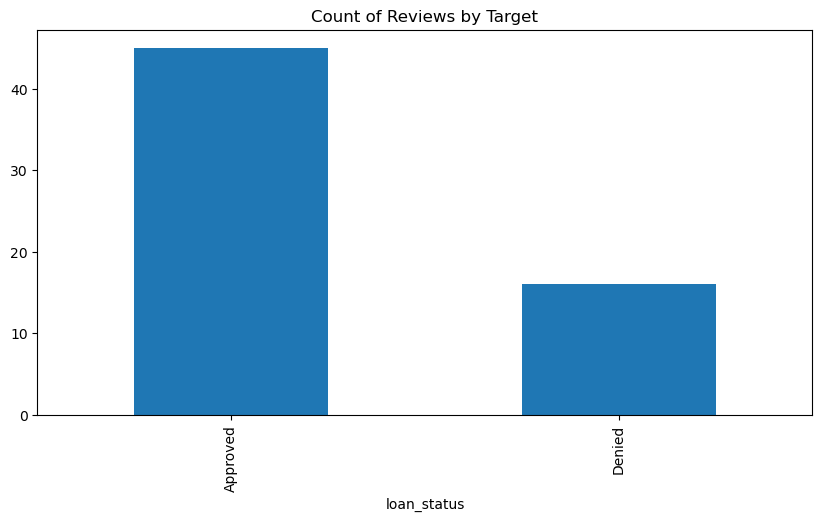

In [7]:
check_class_imbalance(df,df['loan_status'], 'loan_status')

# Class Imbalance exists but we only have 61 rows.

In [8]:
df.dtypes

age                 int64
gender             object
occupation         object
education_level    object
marital_status     object
income              int64
credit_score        int64
loan_status        object
dtype: object

In [9]:
df.describe()

,age,income,credit_score
count,61.000000,61.000000,61.000000
mean,37.081967,78983.606557,709.836066
std,8.424755,33772.025802,72.674888
min,24.000000,25000.000000,560.000000
25%,30.000000,52000.000000,650.000000
50%,36.000000,78000.000000,720.000000
75%,43.000000,98000.000000,770.000000
max,55.000000,180000.000000,830.000000


# Split numeric and categorical features

In [10]:
categorical_features, numeric_features = df.select_dtypes(include="object").drop("loan_status", axis=1), df.select_dtypes(include=["int64", "float64"])

In [11]:
for col in categorical_features.columns:
  print(f"Unqiue column values for col: {col} = {categorical_features[col].unique()}")

Unqiue column values for col: gender = ['Male' 'Female']
Unqiue column values for col: occupation = ['Engineer' 'Teacher' 'Student' 'Manager' 'Accountant' 'Nurse' 'Lawyer'
 'Artist' 'IT' 'Doctor' 'Consultant' 'Analyst' 'Salesman' 'Marketing'
 'Architect' 'Designer' 'Pharmacist' 'Researcher' 'Professor' 'Pilot'
 'Receptionist' 'Banker' 'Writer' 'Chef' 'Veterinarian' 'Sales' 'HR'
 'Electrician' 'Realtor' 'Photographer' 'Editor' 'Programmer' 'Dentist'
 'Musician' 'Psychologist' 'Server' 'Software' 'Stylist']
Unqiue column values for col: education_level = ["Bachelor's" "Master's" 'High School' "Associate's" 'Doctoral']
Unqiue column values for col: marital_status = ['Married' 'Single']


# Visuals

<AxesSubplot:>

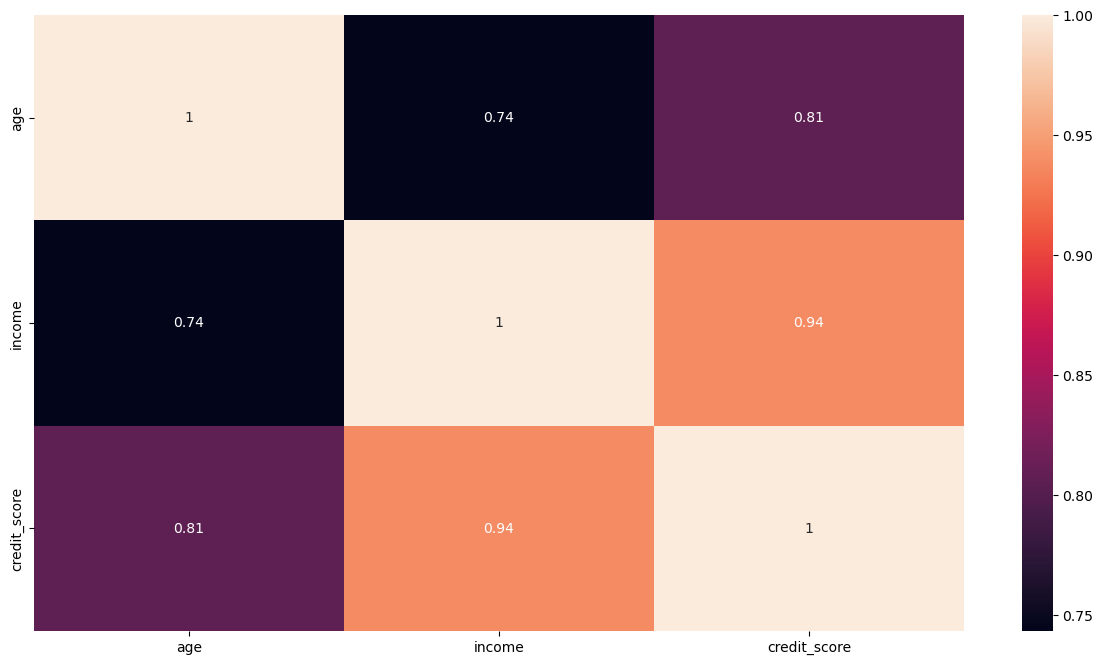

In [12]:
plt.figure(figsize=(15,8))
sns.heatmap(data=numeric_features.corr(), annot=True)

# Separate and Scale feature variables

In [13]:

X,y = df.drop("loan_status", axis=1), df['loan_status']

# Preprocessor Pipeline

In [15]:

preprocessor = create_column_transformer(numeric_features, categorical_features)

# Label encode Target variables

In [16]:
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Baseline Model

In [22]:
model = DummyClassifier(strategy="constant",constant=1)
pipeline = create_pipeline(preprocessor, model)
scores = evaluate_model(X, y, pipeline)
print(f"Mean: {round(np.mean(scores),3)}, STD: {round(np.std(scores),3)}")

Mean: 0.414, STD: 0.028


# Imbalanced Set from our results if we just pick the most common attribute.

# Advanced Metrics

In [23]:
names = ['LR', 'SVC']
models = get_selected_models(names)
testing_selected_models(names, models, X, y, preprocessor)

,Model,Mean,STD
0,LR,0.956614,0.062011
1,SVC,0.949471,0.077335


In [24]:
names = ["RFC", "DTC"]
models = get_selected_models(names)
testing_selected_models(names, models, X, y, preprocessor)

,Model,Mean,STD
0,RFC,0.990476,0.035635
1,DTC,0.977143,0.059201


In [25]:
names = ["GBC"]
models = get_selected_models(names)
testing_selected_models(names, models, X, y, preprocessor)

,Model,Mean,STD
0,GBC,0.957143,0.127242


# Model is overfitting so lets try over sampling methods

# SMOTE Method

In [40]:
X_smote, y_smote = get_over_sampling_methods(X, y, "SMOTE", preprocessor)

# Advanced Model Metrics

In [44]:
names = ['LR', 'SVC']
models = get_selected_models(names)
testing_selected_models(names, models, X_smote, y_smote, preprocessor, sampled=True)

,Model,Mean,STD
1,SVC,0.978947,0.025784
0,LR,0.975439,0.026257


In [62]:
names = ["RFC", "DTC", "GBC"]
models = get_selected_models(names)
testing_selected_models(names, models, X_smote, y_smote, preprocessor, sampled=True)

,Model,Mean,STD
0,RFC,0.996491,0.013129
2,GBC,0.996491,0.013129
1,DTC,0.992982,0.017891


# Test predictions

Validation Test accuracy for RFC: 1.000
Test accuracy for RFC: 1.000
---------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00         2

    accuracy                           1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14



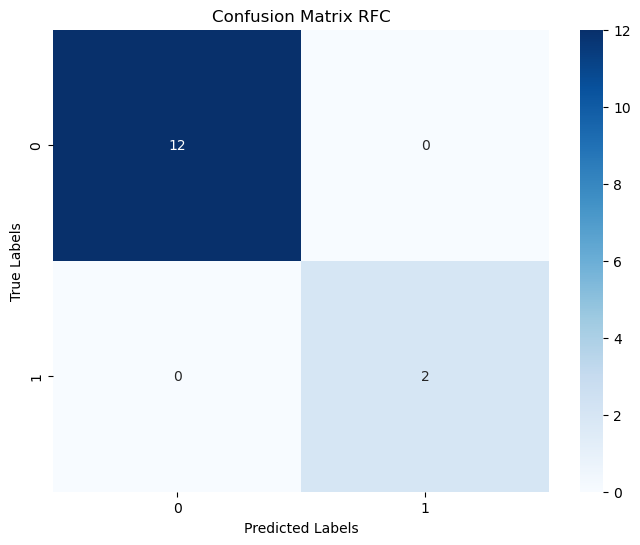

Validation Test accuracy for DTC: 1.000
Test accuracy for DTC: 1.000
---------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00         2

    accuracy                           1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14



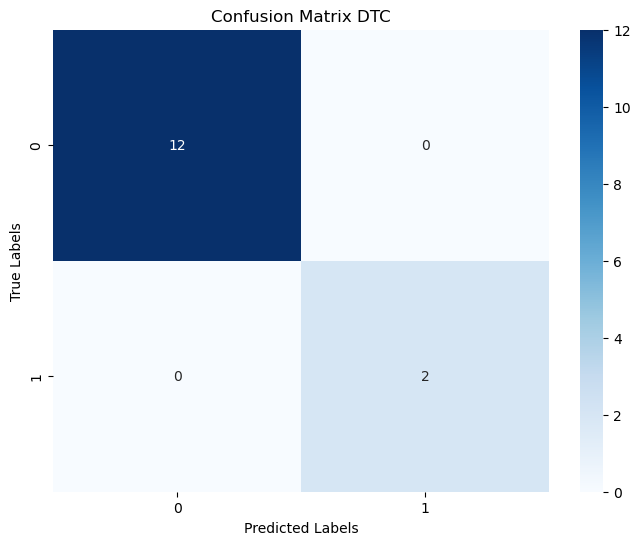

Validation Test accuracy for GBC: 1.000
Test accuracy for GBC: 1.000
---------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00         2

    accuracy                           1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14



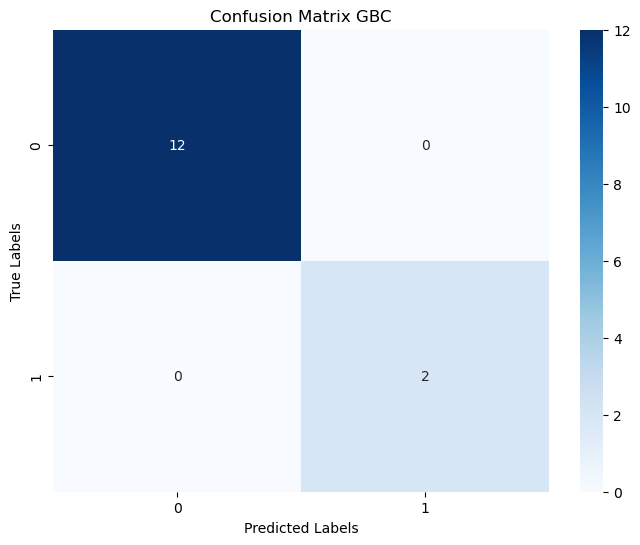

Validation Test accuracy for SVC: 1.000
Test accuracy for SVC: 0.800
---------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.67      1.00      0.80         2

    accuracy                           0.93        14
   macro avg       0.83      0.96      0.88        14
weighted avg       0.95      0.93      0.93        14



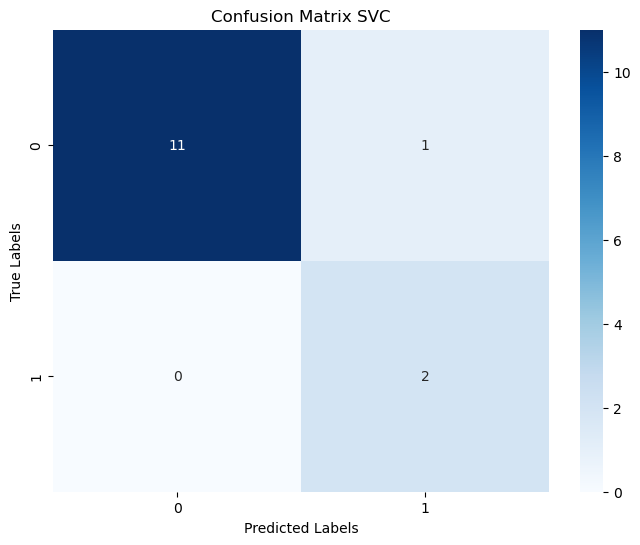

Validation Test accuracy for LR: 1.000
Test accuracy for LR: 0.800
---------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.67      1.00      0.80         2

    accuracy                           0.93        14
   macro avg       0.83      0.96      0.88        14
weighted avg       0.95      0.93      0.93        14



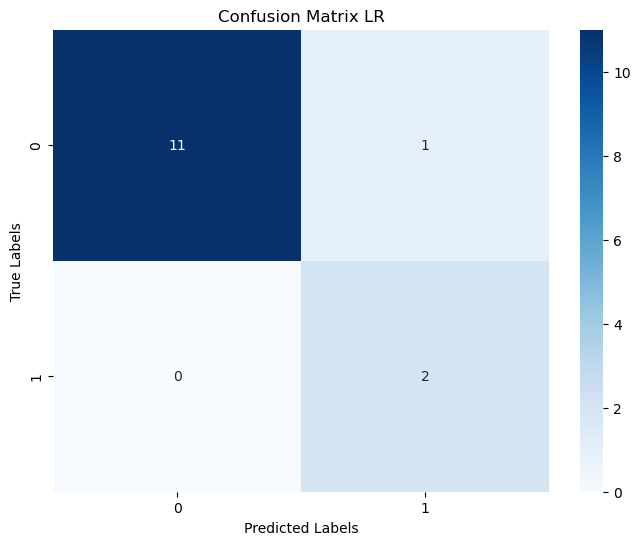

,Model,Validation Accuracy,Test Accuracy
0,RFC,1.0,1.0
1,DTC,1.0,1.0
2,GBC,1.0,1.0
3,SVC,1.0,0.8
4,LR,1.0,0.8


In [65]:
names = ["RFC", "DTC", "GBC", "SVC", "LR"]
models = get_selected_models(names)
test_model_predictions(names, models, X_smote, y_smote)

# Model is overfitting due to a lack of data